In [5]:
from networks.mpnet import MPNet
from networks.costnet import CostNet
from dataset.dataset import get_loader_cost

import torch
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sst_envs.utils import load_data, visualize_point

In [43]:
setup = "default_norm"
mpnet = MPNet(ae_input_size=32, ae_output_size=1024, in_channels=1, state_size=4)

model = "acrobot_obs"
env = 1
traj_id = 233
goal_radius = 2


mpnet.load_state_dict(torch.load('output/acrobot_obs/{}/mpnet/ep10000.pth'.format(setup)))
setup = "default_norm"

costnet = CostNet(ae_input_size=32, ae_output_size=1024, in_channels=1, state_size=4, encoder=mpnet.encoder)
costnet.load_state_dict(torch.load('output/acrobot_obs/{}/cost_transit/ep5000.pth'.format(setup)))
costnet.eval()

# mpnet.eval()
mpnet.train()

def evaluate(start_th, goal_th, env_vox, net, with_grad=False):
    start_goal = torch.cat((start_th.float(), goal_th.float()), dim=1)
    if with_grad:
        sample = net(start_goal, env_vox)   
    else:
        with torch.no_grad():
            sample = net(start_goal, env_vox)         
    return sample.clone()

def visualize(path, start, goal, ax, color='skyblue'):
    path = np.array(path)
    ax.scatter(start[0], start[1], color='orange')
    ax.scatter(goal[0], goal[1], color='red')
    ax.plot(path[:, 0], path[:, 1], color=color)
    ax.scatter(path[:, 0], path[:, 1], color='blue', s=3)
    ax.scatter(path[-1, 0], path[-1, 1], color='orange')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

def distance(point1, point2):
    LENGTH = 20.
    x = np.cos(point1[0] - np.pi / 2)+np.cos(point1[0] + point1[1] - np.pi / 2)
    y = np.sin(point1[0] - np.pi / 2)+np.sin(point1[0] + point1[1] - np.pi / 2)
    x2 = np.cos(point2[0] - np.pi / 2)+np.cos(point2[0] + point2[1] - np.pi / 2)
    y2 = np.sin(point2[0] - np.pi / 2)+np.sin(point2[0] + point2[1] - np.pi / 2)
    return LENGTH*np.sqrt((x-x2)**2+(y-y2)**2)
env_vox_all = torch.from_numpy(np.load('sst_envs/{}_env_vox.npy'.format(model))).float()


In [44]:
env_vox = env_vox_all[env].float().unsqueeze(0).cpu()
costnet.cpu()
ref_path_dict = load_data(model, env, traj_id)
ref_path = ref_path_dict['path']
ref_sg = ref_path_dict['start_goal']
print(ref_path_dict['cost'].sum())
num_sample = 10
node_id = 3
start = ref_path[node_id].copy()
gt = ref_path[node_id+1].copy()
# goal = ref_path[-1].copy()
goal = ref_sg[-1].copy()
start[:2] /= np.pi
start[2:] /= 6
goal[:2] /= np.pi
goal[2:] /= 6
start_th = torch.from_numpy(start).unsqueeze(0).float().repeat([num_sample,1])
goal_th = torch.from_numpy(goal).unsqueeze(0).float().repeat([num_sample,1])


7.119999999999999


In [53]:
sample = evaluate(start_th, goal_th, env_vox.repeat([num_sample, 1, 1, 1]), mpnet)


<IPython.core.display.Javascript object>


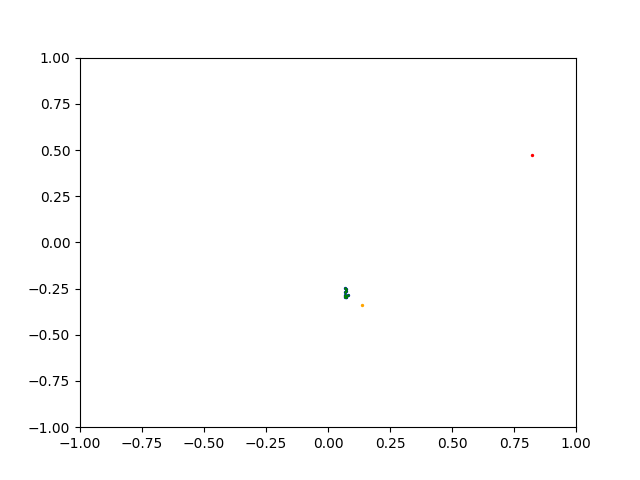

(-1.0, 1.0)

In [54]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(start[0], start[1], color='orange', s=2)
ax.scatter(goal[0], goal[1], color='red', s=2)
ax.scatter(sample[:, 0], sample[:, 1], color='blue', s=2)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

In [55]:
from torch.autograd import Variable
threshold = 1
lr = 1e-2

sample_var = Variable(sample, requires_grad=True)
costs = evaluate(start_th, sample_var, env_vox.repeat([num_sample, 1, 1, 1]), costnet, with_grad=True)
print(costs)
costs.sum().backward()
sample_grad = sample_var.grad
grad_norm = torch.norm(sample_grad, dim=1,keepdim=True)
print(sample_grad, grad_norm)
sample -= lr * sample_grad * (grad_norm > threshold)
# %matplotlib notebook
ax.scatter(sample[:, 0], sample[:, 1], color='green', s=1)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

tensor([[0.4910],
        [0.4741],
        [0.4989],
        [0.4798],
        [0.4823],
        [0.4762],
        [0.4818],
        [0.4952],
        [0.5099],
        [0.4798]], grad_fn=<CloneBackward>)
tensor([[-0.0919,  0.3734,  0.2430, -0.1172],
        [-0.2352,  0.6854,  0.2658, -0.1317],
        [-0.0435,  0.4606,  0.2422, -0.1202],
        [-0.1941,  0.6000,  0.2644, -0.1297],
        [-0.1663,  0.5402,  0.2580, -0.1264],
        [-0.2360,  0.6023,  0.2620, -0.1299],
        [-0.1885,  0.5904,  0.2611, -0.1279],
        [-0.0630,  0.4669,  0.2453, -0.1211],
        [-0.0302,  0.3908,  0.2389, -0.1223],
        [-0.2075,  0.6200,  0.2624, -0.1301]]) tensor([[0.4697],
        [0.7830],
        [0.5358],
        [0.6960],
        [0.6340],
        [0.7099],
        [0.6846],
        [0.5448],
        [0.4750],
        [0.7164]])


(-1.0, 1.0)

In [51]:
costs = evaluate(start_th, sample_var, env_vox.repeat([num_sample, 1, 1, 1]), costnet, with_grad=True)
costs

tensor([[0.5194],
        [0.4488],
        [0.4610],
        [0.4469],
        [0.4484],
        [0.4712],
        [0.4581],
        [0.4635],
        [0.4712],
        [0.4563]], grad_fn=<CloneBackward>)